# Example: The [New York Taxi dataset](https://www.kaggle.com/c/nyc-taxi-trip-duration/data)

This is a large dataset with about 1.5 million data points in 11-dimensional space.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from models.gpyt_regressor import MyGPModel
from models.gpyt_sparse import TitsiasSparseGP
import torch
import torch.nn.functional as F
from torch import optim
import numpy as np
import gpytorch
from gpytorch import likelihoods, mlls
import tqdm

sns.set()
np.random.rand(42)
torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Data processing

In [3]:
df_train_orig_ = pd.read_csv("taxi-data/train.csv", index_col="id")

def process_dataframe(df: pd.DataFrame):
    df = df.copy()
    for col in ['pickup_datetime', 'dropoff_datetime']:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])

    df.drop(columns="store_and_fwd_flag", inplace=True)
    df.drop(columns="vendor_id", inplace=True)
    if 'dropoff_datetime' in df.columns:
        df.drop(columns="dropoff_datetime", inplace=True)
    df = process_datetime_col(df, "pickup_datetime")
    return df
    
def process_datetime_col(df: pd.DataFrame, col, drop=True):
    ser = df[col]
    ser_month = ser.dt.month
    ser_hour = ser.dt.hour
    import re
    date_col = re.sub('datetime', 'month', col)
    df[date_col] = ser_month
    time_col = re.sub('datetime', 'hour', col)
    df[time_col] = ser_hour
    dayoy_col = re.sub('datetime', 'dayofyear', col)
    df[dayoy_col] = ser.dt.dayofyear
    if drop:
        df = df.drop(columns=col)
    return df

In [4]:
df_train_full = process_dataframe(df_train_orig_)

df_test = pd.read_csv("taxi-data/test.csv", index_col="id")
df_test = process_dataframe(df_test)

In [5]:
df_train = df_train_full.sample(54000)

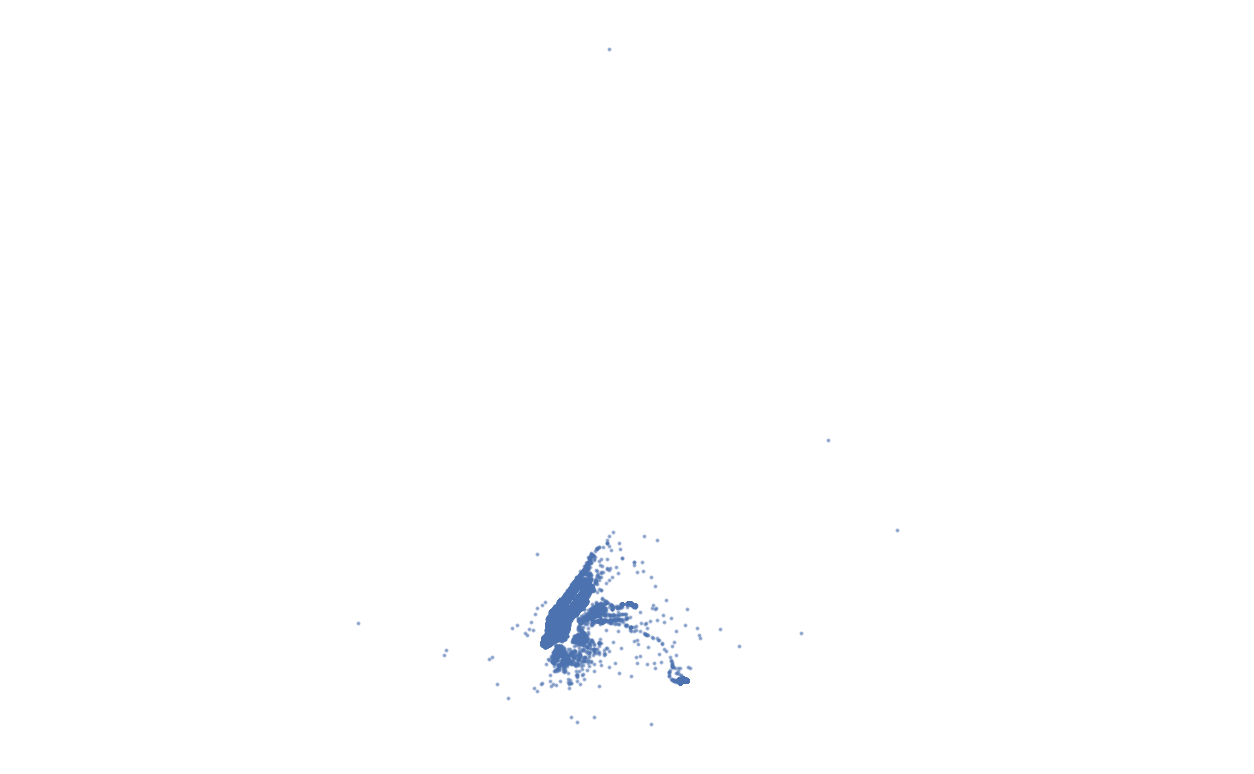

In [6]:
fig = plt.figure(figsize=(8, 5), dpi=80)
plt.scatter(df_train.pickup_longitude, df_train.pickup_latitude,
            s=.6, alpha=.5)
plt.axis('equal')
plt.axis('off')
plt.tight_layout()

In [7]:
df_train.shape

(54000, 9)

The objective function is the RMLSE
$$
    J(s, \hat s) = \sqrt{\sum_i (\log(s_i+1) -\log(\hat s_i + 1)}
$$
we will instead predict $y_i := \log(s_i + 1)$ using the RMSE.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [9]:
y_train = np.log(1 + df_train.trip_duration.values)
X_train = df_train.drop(columns=['trip_duration']).values

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=4/54)

scaler_ = StandardScaler().fit(X_train)
X_train = scaler_.transform(X_train)
X_val = scaler_.transform(X_val)

## Convert to Tensor
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()

In [10]:
print("X train shape:", list(X_train.shape))

X train shape: [50000, 8]


## Baseline: linear regression

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [12]:
linreg_ = LinearRegression().fit(X_train, y_train)

In [13]:
lin_rmse_ = mean_squared_error(y_val, linreg_.predict(X_val), squared=False)
print(lin_rmse_)

0.7465241


In [14]:
from sklearn.ensemble import RandomForestRegressor

In [15]:
rfreg_ = RandomForestRegressor(100).fit(X_train, y_train)

In [16]:
rf_rmse_ = mean_squared_error(y_val, rfreg_.predict(X_val), squared=False)
print(rf_rmse_)

0.4588018205127859


## GP regression

In [58]:
from typing import List

import gc

gc.collect()
torch.cuda.empty_cache()

In [18]:
def train(model, likelihood: likelihoods.Likelihood, mll, optimizer: optim.Optimizer,
          X_train, y_train):
    model.train()
    likelihood.train()
    
    optimizer.zero_grad()
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    """
    def closure():
        optimizer.zero_grad()
        output = model(X_train)
        loss = -mll(output, y_train)
        loss.backward()
        return loss
    
    loss = optimizer.step(closure)
    """
    output = model(X_train)
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()
    
    loss = loss.cpu()
    return loss.item()

def validate(model, likelihood, X_val, y_val):
    with torch.no_grad(), gpytorch.settings.max_root_decomposition_size(25):
        model.eval()
        likelihood.eval()
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        with gpytorch.settings.max_preconditioner_size(40), gpytorch.settings.fast_pred_var(),\
                gpytorch.settings.skip_posterior_variances():
            y_val_preddist = likelihood(model(X_val))  # predictive distribution of yval | Xtrain,ytrain
        val_loss = F.mse_loss(y_val_preddist.mean, y_val) ** 0.5
    
        val_loss = val_loss.cpu()
        return val_loss.item()

### Training

In [19]:
results_dict = dict()

In [20]:
# empty cell to avoid accidents

In [71]:
num_induce_list = [800]

In [72]:
for num_induce in num_induce_list:
    l_hood = likelihoods.GaussianLikelihood()
    inducing_idx = np.random.choice(np.arange(X_train.shape[0]), size=num_induce,
                                    replace=False)
    inducing_pts = X_train[inducing_idx]

    model = TitsiasSparseGP(X_train, y_train, inducing_pts, l_hood)
    marg_hood = mlls.ExactMarginalLogLikelihood(l_hood, model)
    optimizer = optim.Adam(model.parameters(), lr=.05)
    # optimizer = optim.LBFGS(model.parameters(), lr=.06)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=.5)

    model = model.to(device)
    l_hood = l_hood.to(device)
    
    num_epochs = 150

    eprange = tqdm.notebook.trange(num_epochs, desc="%d pts" % num_induce)
    all_losses = []  # marg losses
    all_val_losses = []  # all val RMSE
    try:
        for epoch in eprange:
            loss_ = train(model, l_hood, marg_hood, optimizer, X_train, y_train)
            all_losses.append(loss_)
            if (epoch + 1) % 5 == 0:
                val_loss_ = validate(model, l_hood, X_val, y_val)
                all_val_losses.append(val_loss_)
            if epoch > 0:
                eprange.set_postfix({"MLL": loss_, "Val RMSE": val_loss_})
            else:
                eprange.set_postfix({"MLL": loss_})
            scheduler.step(loss_)
        torch.cuda.empty_cache()
    finally:
        # Record the results
        results_dict[num_induce] = [all_losses, all_val_losses]
        torch.cuda.empty_cache()

RuntimeError: CUDA out of memory. Tried to allocate 154.00 MiB (GPU 0; 3.82 GiB total capacity; 1.29 GiB already allocated; 16.38 MiB free; 1.64 GiB reserved in total by PyTorch)

ValueError: zero-size array to reduction operation minimum which has no identity

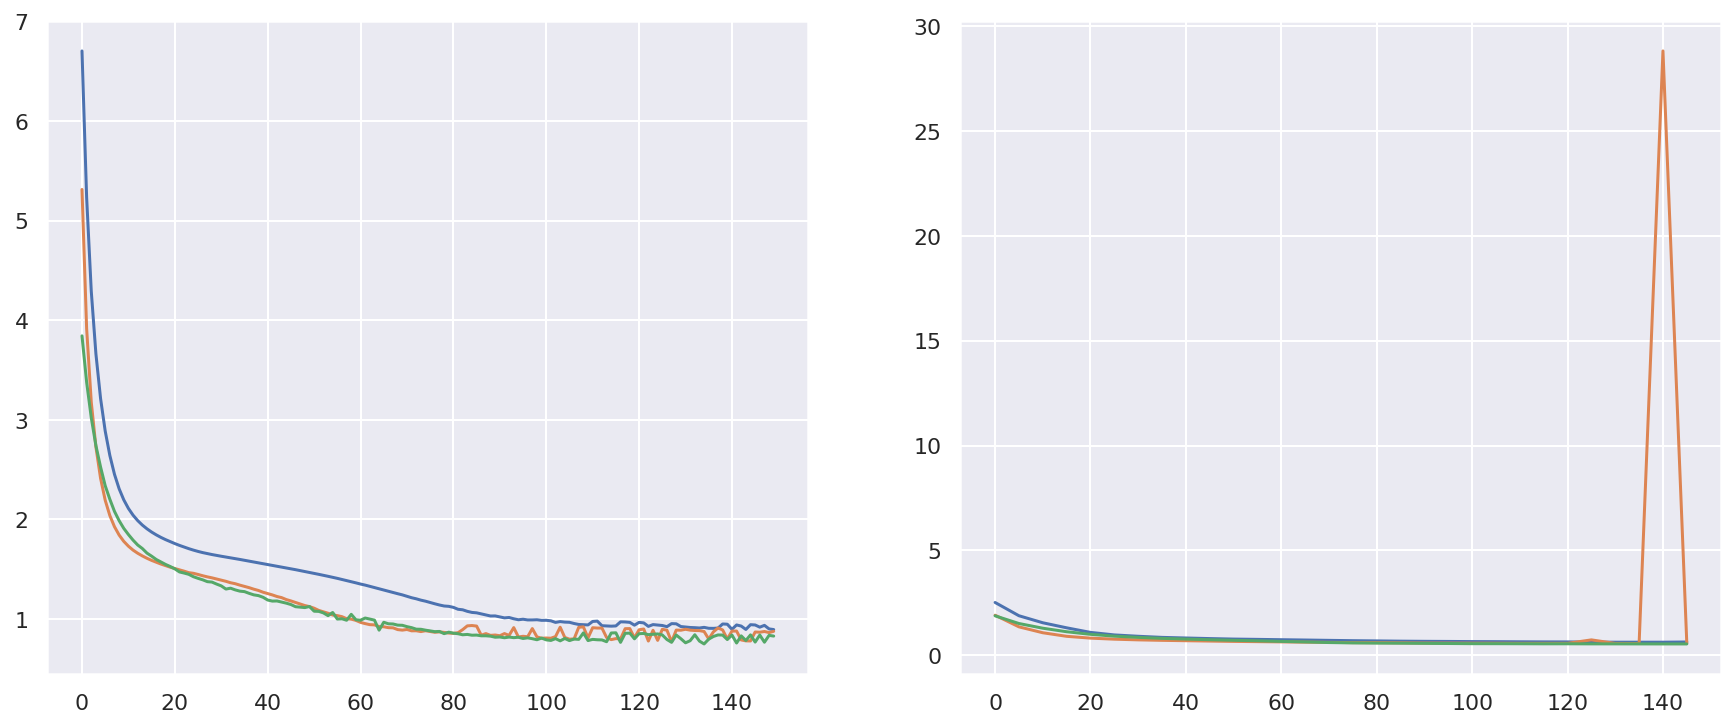

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for num_, [mlloss, valrmse_] in results_dict.items():
    axes[0].plot(mlloss, label="%d induc. pts" % (num_,))
    
    axes[1].plot(np.arange(0, num_epochs, 5), valrmse_, label="%d induc. pts (best RMSE %.4g)"
                 % (num_,  np.min(valrmse_)))

axes[0].set_yscale('log')
axes[0].legend()
axes[0].set_title("Marginal log-likelihood")

axes[1].hlines(lin_rmse_, 0, num_epochs, label="Linear regression", color="r", ls='--')
axes[1].hlines(rf_rmse_, 0, num_epochs, label="RF regression", color="g", ls='--')
axes[1].legend()
axes[1].set_title("Validation RMSE")
axes[1].set_ylim(0.2, 3)

fig.suptitle("Titsias GP regression, NYC Taxi "
             "Trip dataset\n{:d} points".format(X_train.shape[0]),
             y=1.02)
fig.tight_layout()

In [47]:
fig.savefig("NYCTaxi_Titsias_{:d}pts_Matern32.pdf".format(X_train.shape[0]),
            bbox_inches='tight')
fig.savefig("NYCTaxi_Titsias_{:d}pts_Matern32.png".format(X_train.shape[0]),
            bbox_inches='tight')